# Analysing 1D SWE model outputs across a variety of different parameters

Recall the SWE:

\begin{align*}
    \partial_t u + u \cdot \nabla u + g \nabla \eta - \nu \nabla^2 u &= 0, \\
    \partial_t \eta + \nabla \cdot ((H + \eta) u) &= 0.
\end{align*}

For our paper simulation study -- and thus, also in this notebook -- we are looking at analysing the results of running statFEM for the SWE, with different viscosity parameters $\nu$, topographies $H$, and observation intervals. We will mainly analyse outputs in terms of the relative RMSE:

\begin{equation*}
    \mathrm{RMSE} = \frac{\Vert y_m - H(u_m, h_m)\Vert}{\Vert y_m \Vert},
\end{equation*}

and also the (negative) log-likelihoods for a probabilistic metric for comparison.

## Initialising data and getting things set up

Here we first define some helper functions and the like, to be used later on. We also import libraries and some definitions for the figure sizes:

In [3]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from glob import glob
from tabulate import tabulate

import sys
sys.path.insert(0, "../src")
from figures import figure_sizes, texp

def errors_from_output_file(output_file, prior=False):
    """ Read in errors from output file. """
    checkpoint = h5py.File(output_file, "r")
    nu = checkpoint["/"].attrs["nu"]
    s = checkpoint["/"].attrs["s"]
    nt_skip = checkpoint["/"].attrs["nt_skip"]
    k = checkpoint["/"].attrs["k"]
    linear = checkpoint["/"].attrs["linear"]
    
    # just verify we are doing the correct thing
    assert checkpoint["/"].attrs["rho_h"] == 2e-3
    t = checkpoint["/t"][:]
    t_obs = checkpoint["/t_obs"][:]
    dgp_error = checkpoint["/dgp_error"][:, 0]
    rmse_rel = checkpoint["/rmse_rel"][:]
    
    # load in the errors and stuff
    dgp_error_ds = xr.DataArray(data=dgp_error[:, np.newaxis, np.newaxis, np.newaxis],
                                coords=dict(t=t,
                                            nu=np.array([nu]),
                                            s=np.array([s]),
                                            nt_skip=np.array([nt_skip])),
                                name="dgp_error")
    rmse_rel_ds = xr.DataArray(data=rmse_rel[:, np.newaxis, np.newaxis, np.newaxis],
                               coords=dict(t=t_obs,
                                           nu=np.array([nu]),
                                           s=np.array([s]),
                                           nt_skip=np.array([nt_skip])),
                               name="rmse_rel")
    if not prior:
        lml = checkpoint["/lml"][:]
        checkpoint.close()
        
        lml_ds = xr.DataArray(data=lml[:, np.newaxis, np.newaxis, np.newaxis],
                              coords=dict(t=t_obs,
                                          nu=np.array([nu]),
                                          s=np.array([s]),
                                          nt_skip=np.array([nt_skip])),
                              name="lml")
        return xr.merge([dgp_error_ds, rmse_rel_ds, lml_ds])
    else:
        checkpoint.close()
        return xr.merge([dgp_error_ds, rmse_rel_ds])

In [4]:
output_files_post = glob(
    "../outputs/swe-tidal-redo/nonlinear-posterior-s-*.h5")

errors_ds = []
for output_file in output_files_post:
    e = errors_from_output_file(output_file, prior=False)
    errors_ds.append(e)

errors_post = xr.merge(errors_ds)
errors_post

<xarray.Dataset>
Dimensions:    (t: 21600, nu: 7, s: 8, nt_skip: 4)
Coordinates:
  * t          (t) float64 2.0 4.0 6.0 8.0 ... 4.32e+04 4.32e+04 4.32e+04
  * nu         (nu) float64 1.0 100.0 1e+03 1e+04 2.5e+04 5e+04 1e+05
  * s          (s) float64 1e+03 2e+03 3e+03 4e+03 5e+03 6e+03 7e+03 8e+03
  * nt_skip    (nt_skip) int64 1 30 150 300
Data variables:
    dgp_error  (t, nu, s, nt_skip) float64 0.2396 0.2396 0.2396 ... 0.8235 1.122
    rmse_rel   (t, nu, s, nt_skip) float64 0.02915 0.02915 0.02915 ... nan nan
    lml        (t, nu, s, nt_skip) float64 -1.1e+03 -1.1e+03 ... nan nan

In [5]:
output_files_prior = glob(
    "../outputs/swe-tidal-redo/nonlinear-prior-s-*.h5")

errors_ds = []
for output_file in output_files_prior:
    e = errors_from_output_file(output_file, prior=True)
    errors_ds.append(e)

errors_prior = xr.merge(errors_ds)
errors_prior

<xarray.Dataset>
Dimensions:    (t: 21600, nu: 7, s: 8, nt_skip: 1)
Coordinates:
  * t          (t) float64 2.0 4.0 6.0 8.0 ... 4.32e+04 4.32e+04 4.32e+04
  * nu         (nu) float64 1.0 100.0 1e+03 1e+04 2.5e+04 5e+04 1e+05
  * s          (s) float64 1e+03 2e+03 3e+03 4e+03 5e+03 6e+03 7e+03 8e+03
  * nt_skip    (nt_skip) int64 30
Data variables:
    dgp_error  (t, nu, s, nt_skip) float64 0.2398 0.2394 0.2392 ... 1.434 1.434
    rmse_rel   (t, nu, s, nt_skip) float64 0.02969 0.02969 0.02969 ... nan nan

## Paper plots: checking performance across observation intervals

First we plot the results across the different observation intervals to see how things stack up across time. We first look at the relative errors across time, for different values of `nt_skip`, for the true value of $c$:

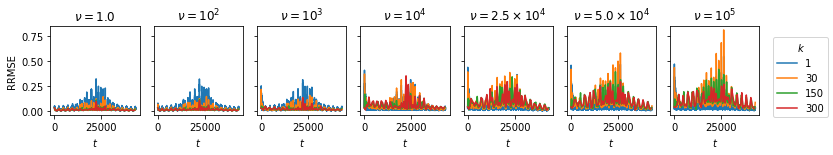

In [16]:
# assert errors_nonlinear.coords["c"][1] == 10.
nus =  errors_post.coords["nu"].to_numpy()
nu_labels = [fr"$\nu = {texp(f'{nu:.1e}', False)}$" for nu in nus]

p = errors_post.rmse_rel.isel(s=1).interpolate_na(dim="t").plot(
    hue="nt_skip", col="nu",
    figsize=(1.5 * figure_sizes["fullwidth"], 0.3 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

# figure customization
p.figlegend.set_title(r"$k$")
# p.figlegend.remove()

for i, ax in enumerate(p.axes.flat):
    ax.set_title(nu_labels[i])

for ax in p.axes[0, :]:
    ax.set_xlabel(r"$t$")

for ax in p.axes[:, 0]:
    ax.set_ylabel("RRMSE") 
    
plt.savefig("../figures/nt-skip-nu-grid.pdf", dpi=600)

And, again, for the relative errors for different $c$ values for the linear model:

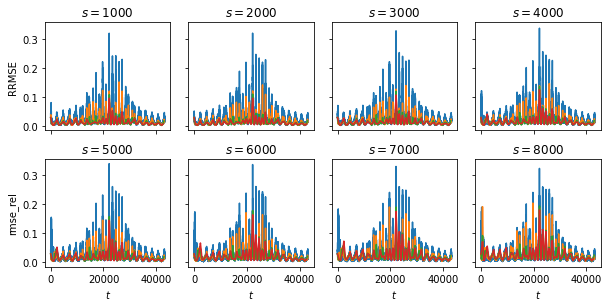

In [7]:
p = errors_post.rmse_rel.isel(nu=0).interpolate_na(dim="t").plot(
    hue="nt_skip", col="s", col_wrap=4,
    figsize=(1.2 * figure_sizes["fullwidth"], 0.6 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

# figure customization
p.figlegend.set_title(r"$k$")
p.figlegend.remove()

s_all =  errors_post.coords["s"].to_numpy()
s_labels = [fr"$s = {s:.0f}$" for s in s_all]
for i, ax in enumerate(p.axes.flat):
    ax.set_title(s_labels[i])

for ax in p.axes[-1, :].flat:
    ax.set_xlabel(r"$t$")

p.axes[0, 0].set_ylabel("RRMSE") 
plt.savefig("../figures/nt-skip-s-grid.pdf", dpi=600)

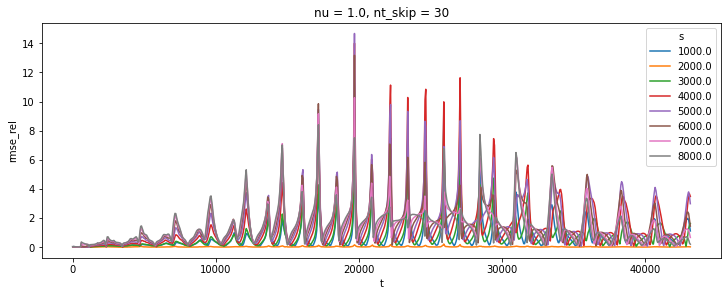

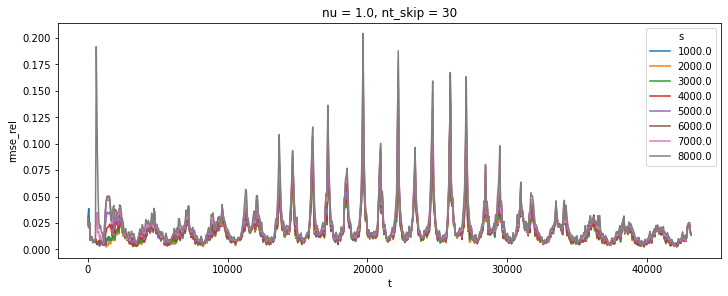

In [17]:
fig, ax = plt.subplots(1, 1,  constrained_layout=True, figsize=(10, 4))
p = errors_prior.rmse_rel.isel(nu=0).interpolate_na(dim="t").plot(hue="s", ax=ax)
plt.show()

fig, ax = plt.subplots(1, 1,  constrained_layout=True, figsize=(10, 4))
p = errors_post.rmse_rel.isel(nu=0, nt_skip=1).interpolate_na(dim="t").plot(hue="s", ax=ax)
plt.show()

The results are decent across the the board with minor stratifications between the models across for different `nt_skip` values, but with greater stratification from changing parameter values. This leads to the conclusion that the different time-differences between observations does not drive the variation in model performance, in this scenario. We now tabulate these results, highlighting the results with the lowest RRMSE:

In [9]:
ave_rmse = errors_post.isel(s=1).mean(dim="t", skipna=True).rmse_rel
dat = ave_rmse.to_numpy().T

from scipy.stats import f_oneway

print(f_oneway(*[col for col in dat.T]))
print(tabulate(dat,
               ave_rmse.coords["nu"].to_numpy(),
               showindex=ave_rmse["nt_skip"].to_numpy()))
                 
def format_col(col, exp=False):
    min_loc = col.argmin()
    out = col.astype(str)
    
    for i in range(len(col)):
        if i == min_loc:
            if exp:
                out[i] = fr"$\mathbf{{{col[i]:.6e}}}$"
            else:
                out[i] = fr"$\mathbf{{{col[i]:.6f}}}$"
        else:
            if exp:
                out[i] = fr"${col[i]:.6e}$"
            else:
                out[i] = fr"${col[i]:.6f}$"

    return np.array(out)
            
dat_formatted = np.apply_along_axis(format_col, 0, dat)

with open("../figures/nt-skip-nu-table.tex", "w") as f:
    f.write(tabulate(dat_formatted,
                     ave_rmse.coords["nu"].to_numpy(),
                     showindex=ave_rmse["nt_skip"].to_numpy(),
                     tablefmt="latex_raw"))

F_onewayResult(statistic=10.416506196368838, pvalue=2.16729121868262e-05)
           1.0      100.0     1000.0    10000.0    25000.0    50000.0    100000.0
---  ---------  ---------  ---------  ---------  ---------  ---------  ----------
  1  0.0234765  0.0236314  0.024746   0.029502   0.0361048  0.0384213   0.0408218
 30  0.0167852  0.0172403  0.0211798  0.0441571  0.0699125  0.0809145   0.0919934
150  0.0124499  0.0132926  0.0195018  0.0508671  0.0836594  0.0955209   0.106265
300  0.0127417  0.0139384  0.0216698  0.0587325  0.0867676  0.0965963   0.104438


/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


In [10]:
ave_rmse = errors_post.isel(nu=1).mean(dim="t", skipna=True).rmse_rel

dat = ave_rmse.to_numpy().T
print(f_oneway(*[col for col in dat.T]))

print(tabulate(dat, 
               ave_rmse.coords["s"].to_numpy(),
               showindex=ave_rmse["nt_skip"].to_numpy()))

dat_formatted = np.apply_along_axis(format_col, 0, dat)

with open("../figures/nt-skip-c-table.tex", "w") as f:
    f.write(tabulate(dat_formatted, 
                     ave_rmse.coords["s"].to_numpy(),
                     showindex=ave_rmse["nt_skip"].to_numpy(),
                     tablefmt="latex_raw"))

F_onewayResult(statistic=4.10227314617239, pvalue=0.0042937316070541486)
        1000.0     2000.0     3000.0     4000.0     5000.0     6000.0     7000.0     8000.0
---  ---------  ---------  ---------  ---------  ---------  ---------  ---------  ---------
  1  0.0237656  0.0236314  0.0237835  0.0241249  0.0244958  0.0248017  0.0250225  0.0252001
 30  0.0177295  0.0172403  0.0176479  0.0188262  0.0203847  0.0220692  0.0237805  0.0254098
150  0.0138512  0.0132926  0.0140881  0.0159576  0.0182786  0.0206737  0.0228212  0.0246817
300  0.0147795  0.0139384  0.0150758  0.0176715  0.0206579  0.0234726  0.0257827  0.027608


/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


## Paper plots: checking performance for misspecified model parameters, with a fixed observation interval

First we plot the RRMSE values across the grid of $\nu$ and $c$ values, both a priori and a posteriori. Across different values this stratifies and results in reasonable results. As previous we see that at $\nu = 1$ the dynamics seems to change and is much less amenable to being updated with data, due to the damping -- perhaps there is a dynamical bifurcation here?

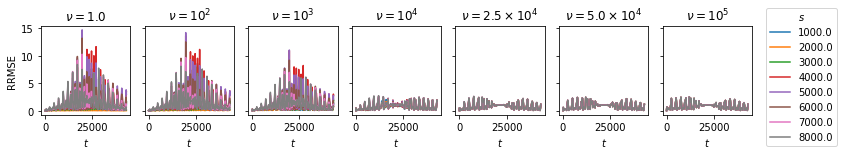

In [11]:
errors_temp = xr.concat([errors_prior, errors_post], 
                        pd.Index(["Prior", "Posterior"], name="Model"))

p = errors_temp.rmse_rel.interpolate_na(dim="t").isel(Model=0, nt_skip=1).plot(
    x="t", col="nu", hue="s", 
    figsize=(1.5 * figure_sizes["fullwidth"], 0.3 * figure_sizes["fullwidth"]),
    sharex=True, sharey="row")

for i, ax in enumerate(p.axes[0, :]):
    ax.set_title(nu_labels[i])

for ax in p.axes[0, :]:
    ax.set_xlabel(r"$t$")
    
p.axes[0, 0].set_ylabel("RRMSE")
p.figlegend.set_title("$s$")

plt.savefig("../figures/nu-c-rrmse-prior-layout.pdf", dpi=600)

In [12]:
errors_subset = errors_post.drop(labels=["dgp_error"])
errors_subset["lml"] *= -1  # convert to negative LML
errors_subset_array = errors_subset.to_array("metric")

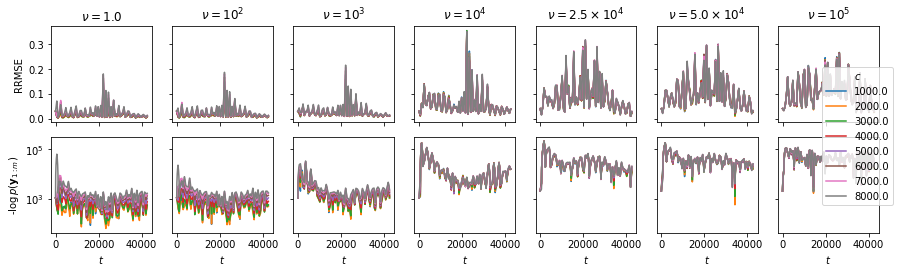

In [13]:
p = errors_subset_array.interpolate_na(dim="t").isel(nt_skip=-1).plot(
    x="t", col="nu", hue="s", row="metric",
    figsize=(1.6 * figure_sizes["fullwidth"], 
             0.5 * figure_sizes["fullwidth"]),
    sharex=True, sharey="row")
p.set_titles("")
plt.tight_layout()

nus =  errors_temp.coords["nu"].to_numpy()
labels = [fr"$\nu =$ {nu:.1e}" for nu in nus]
labels[0] = "Linear"

for i, ax in enumerate(p.axes[0, :]):
    ax.set_title(nu_labels[i])

for ax in p.axes[1, :]:
    ax.set_yscale("log")
    ax.set_xlabel(r"$t$")

p.axes[0, 0].set_ylabel("RRMSE")
p.axes[1, 0].set_ylabel(r"-$\log p(\mathbf{y}_{1:m})$")

p.figlegend.set_title("$c$")
p.fig.savefig("../figures/nu-c-rrmse-nlml-layout.pdf", 
              bbox_inches="tight")
plt.show()

Now, we plot the results across the same grid, however this time we plot the log-marginal likelihoods:

Now, we tabulate these results, first in a plot and then in a LaTeX table, to be plugged into the paper. Results confirm what the above plots suggest. Performance is best for the models which have the smaller viscosity parameters, and those with $c = 10$:

0.016785192905707794


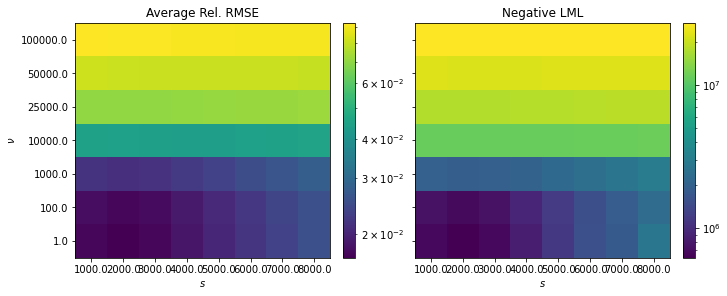

In [14]:
import matplotlib.colors as colors

# mean the RMSEs, sum the LMLs
total_rmse = errors_post.isel(nt_skip=1).mean(dim="t").rmse_rel
total_lml = np.abs(errors_post.isel(nt_skip=1).lml).sum(dim="t")

rmse_array = total_rmse.to_numpy()[:, :]
lml_array = total_lml.to_numpy()[:, :]

print(rmse_array.min())

fig, ax = plt.subplots(1, 2, 
                       figsize=(10, 4), constrained_layout=True,
                      sharey=True)
im = ax[0].pcolormesh(range(len(total_rmse.coords["s"].to_numpy())), 
                      range(len(total_rmse.coords["nu"].to_numpy())),
                      rmse_array,
                      norm=colors.LogNorm(vmin=rmse_array.min(), 
                                          vmax=rmse_array.max()))
ax[0].set_xticks(range(len(total_rmse.coords["s"].to_numpy())), 
                 total_rmse.coords["s"].to_numpy())
ax[0].set_yticks(range(len(total_rmse.coords["nu"].to_numpy())), 
                 total_rmse.coords["nu"].to_numpy())
ax[0].set_xlabel(r"$s$")
ax[0].set_ylabel(r"$\nu$")
ax[0].set_title("Average Rel. RMSE")
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(range(len(total_lml.coords["s"].to_numpy())), 
                      range(len(total_lml.coords["nu"].to_numpy())),
                      lml_array,
                      norm=colors.LogNorm(vmin=lml_array.min(), 
                                          vmax=lml_array.max()))
ax[1].set_xticks(range(len(total_lml.coords["s"].to_numpy())), 
                 total_lml.coords["s"].to_numpy())
ax[1].set_yticks(range(len(total_lml.coords["nu"].to_numpy())), 
                 total_lml.coords["nu"].to_numpy())
ax[1].set_xlabel(r"$s$")
ax[1].set_title("Negative LML")
plt.colorbar(im, ax=ax[1])

plt.savefig("../figures/nu-c-rrmse-lml-table-color.pdf", dpi=600)

In [15]:
print(tabulate(lml_array, 
               headers=total_lml.coords['s'].to_numpy(),
               showindex=total_lml.coords['nu'].to_numpy()))

lml_formatted = np.apply_along_axis(format_col, 0, lml_array, True)
with open("../figures/nu-c-lml-table.tex", "w") as f:
    f.write(tabulate(lml_formatted,
                     headers=total_lml.coords['s'].to_numpy(),
                     showindex=total_lml.coords['nu'].to_numpy(),
                     tablefmt="latex_raw"))

                  1000.0            2000.0            3000.0            4000.0       5000.0       6000.0       7000.0       8000.0
------  ----------------  ----------------  ----------------  ----------------  -----------  -----------  -----------  -----------
     1  668396            618513            670170            846241            1.14548e+06  1.56049e+06  1.77509e+06  2.73897e+06
   100  733478            679986            731696            912108            1.20236e+06  1.53706e+06  1.86176e+06  2.31174e+06
  1000       1.98336e+06       1.89809e+06       1.91843e+06       2.03198e+06  2.21006e+06  2.43268e+06  2.69305e+06  2.98705e+06
 10000       1.13194e+07       1.1266e+07        1.12357e+07       1.12607e+07  1.13283e+07  1.14196e+07  1.15254e+07  1.16462e+07
 25000       1.77431e+07       1.76822e+07       1.76996e+07       1.78088e+07  1.79599e+07  1.81299e+07  1.83002e+07  1.84791e+07
 50000       2.23214e+07       2.21196e+07       2.20919e+07       2.21367e+07  2.2

/home/cpd32@ad.eng.cam.ac.uk/miniconda3/envs/swfe/lib/python3.10/site-packages/tabulate/__init__.py:1475: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if showindex == "default" and index is not None:


## Development plots: leftovers that we use to check models
Here, we plot the posterior. On the left, below, are the results for the linear model, and on the right are the results of the nonlinear model. Results are sensible with quite significant stratification across the $c$ values. We see that there is a reasonable drop in the relative errors in comparison to the prior:

In [14]:
p = errors_nonlinear.lml.interpolate_na(dim="t").isel(nt_skip=3).plot(
    x="t", col="nu", hue="c", yscale="log",
    figsize=(1.5 * figure_sizes["fullwidth"], 0.3 * figure_sizes["fullwidth"]),
    sharex=True, sharey=True)

nus =  errors_temp.coords["nu"].to_numpy()
labels = [fr"$\nu =$ {nu:.1e}" for nu in nus]
labels[0] = "Linear"
p.axes[0, 0].set_ylabel(r"-$\log p(\mathbf{y}_{1:m})$")

for i, ax in enumerate(p.axes[0, :]):
    ax.set_title(labels[i])

for ax in p.axes[0, :]:
    ax.set_xlabel(r"$t$")
    
p.figlegend.set_title("$c$")
plt.show()

NameError: name 'errors_nonlinear' is not defined

In [ ]:
errors_prior.rmse_rel.interpolate_na(dim="t").isel(nu=[0, 1]).plot(
    hue="c", col="nu", sharey=False)

errors_nonlinear.rmse_rel.interpolate_na(dim="t").isel(nt_skip=3, nu=[0, 1]).plot(
    hue="c", col="nu", sharey=False, ylim=[0., 2.4])
plt.show()

Next, we plot these same results, but we instead use the log-marginal likelihood as the metric. The stratification here becomes more apparent across the board:

In [ ]:
np.abs(errors_nonlinear).lml.interpolate_na(dim="t").isel(nt_skip=3, nu=[0, 1]).plot(
    hue="c", col="nu", sharey=False, yscale="log")
plt.show()

And now for total comparison we show all of these results, for all the $\nu$ values:

In [ ]:
np.abs(errors_nonlinear.lml).isel(nt_skip=3).interpolate_na(dim="t").plot(
    hue="c", col="nu", sharey=True, yscale="log")
plt.show()

Next, we plot the results for the true value of $c$, for the various values of $\nu$. We see that there is a drastic change in the dynamics as we increase $\nu \geq 1$; once setting $\nu = 1$ this induces a degree of mismatch which results in the model not improving *a posteriori*:

In [ ]:
nu = [0, 1, 2, 3, 4]
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4), sharey=True)
errors_prior.rmse_rel.isel(nu=nu, c=2).interpolate_na(dim="t").plot(
    hue="nu", ax=ax[0], add_legend=False)
ax[0].set_title("Prior, $c = 10$")
errors_nonlinear.rmse_rel.isel(nt_skip=3, nu=nu, c=2).interpolate_na(dim="t").plot(
    hue="nu", ax=ax[1], add_legend=True)
ax[1].set_title("Posterior, $c = 10$")
plt.show()

Next, we plot the log-marginal likelihoods for the true value $c = 10$, again stratified across the different $\nu$ values. In this case we see that there is a clear stratification as a result of the $\nu$.

In [ ]:
nu = nu
np.abs(errors_nonlinear.lml).isel(nt_skip=3, nu=nu, c=2).interpolate_na(dim="t").plot(
    hue="nu", add_legend=True, yscale="log")
plt.show()

In [ ]:
np.abs(errors_nonlinear.lml).isel(nt_skip=3, nu=nu).interpolate_na(dim="t").plot(
    hue="nu", col="c", sharey=True, yscale="log")
plt.show()

In [ ]:
import matplotlib.colors as colors

# mean the RMSEs, sum the LMLs
total_rmse = errors_nonlinear.isel(nt_skip=3).mean(dim="t").rmse_rel
total_lml = np.abs(errors_nonlinear.isel(nt_skip=3).lml).sum(dim="t")

rmse_array = total_rmse.to_numpy()[:, :]
lml_array = total_lml.to_numpy()[:, :]

fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
im = ax[0].pcolormesh(range(len(total_rmse.coords["c"].to_numpy())), 
                      range(len(total_rmse.coords["nu"].to_numpy())),
                      rmse_array,
                      norm=colors.LogNorm(vmin=rmse_array.min(), 
                                          vmax=rmse_array.max()))
ax[0].set_xticks(range(len(total_rmse.coords["c"].to_numpy())), 
                 total_rmse.coords["c"].to_numpy())
ax[0].set_yticks(range(len(total_rmse.coords["nu"].to_numpy())), 
                 total_rmse.coords["nu"].to_numpy())
ax[0].set_title("Average Rel. RMSE")
plt.colorbar(im, ax=ax[0])

im = ax[1].pcolormesh(range(len(total_lml.coords["c"].to_numpy())), 
                      range(len(total_lml.coords["nu"].to_numpy())),
                      lml_array,
                      norm=colors.LogNorm(vmin=lml_array.min(), 
                                          vmax=lml_array.max()))
ax[1].set_xticks(range(len(total_lml.coords["c"].to_numpy())), 
                 total_lml.coords["c"].to_numpy())
ax[1].set_yticks(range(len(total_lml.coords["nu"].to_numpy())), 
                 total_lml.coords["nu"].to_numpy())
ax[1].set_title("Negative LML")
plt.colorbar(im, ax=ax[1])
plt.show()

In [ ]:
total_lml.plot(marker="o", col="nu", yscale="log", sharey=False)
plt.show()

In [ ]:
total_lml.plot(marker="o", col="c", xscale="symlog", yscale="log",sharey=False)
plt.show()

In [ ]:
print(tabulate(total_lml, 
               headers=total_lml.coords['c'].to_numpy(),
               showindex=total_lml.coords['nu'].to_numpy()))